# RobustRandomCutForest implementation using MSTICPy library with small 4-dimensional sample data

In [7]:
import msticpy as mp

print(mp.__version__)
mp.init_notebook()

2025-05-27 07:53:20,110: WARNING - Could not find msticpyconfig.yaml in standard search. (nbinit#737)


2.16.2


## Phase 1. Create sample datasets 

In [2]:
# MSTICPy is Microsoft's threat intelligence library designed for security analytics
import numpy as np
import pandas as pd

# Set random seed for reproducibility across different execution runs
# This ensures that the same random numbers are generated each time the code runs
# which is crucial for debugging and consistent results in research environments
np.random.seed(42)

# Define parameters for synthetic dataset generation
# These parameters control the size and characteristics of our test dataset
n_normals = 990  # Total number of data points in the dataset
n_outliers = 10  # Number of anomalous data points to inject
n_features = 4  # Number of dimensions/features in our feature space

# Generate normal (non-anomalous) data points using standard normal distribution
# np.random.randn generates samples from standard normal distribution (mean=0, std=1)
# We scale by 0.5 to create tighter clusters and make anomalies more distinct
print("Generating normal data points...")
X_normal = 0.5 * np.random.randn(n_normals - n_outliers, n_features)

# Create two distinct clusters by adding and subtracting offset values
# This simulates real-world data where normal behavior forms distinct patterns
# np.r_ concatenates arrays along the first axis (row-wise concatenation)
X_clustered = np.r_[X_normal + 2, X_normal - 2]
sample_indices = np.random.choice(X_clustered.shape[0], n_normals, replace=False)
X_sampled = X_clustered[sample_indices]
print(f"Generated {len(X_sampled)} normal data points with {n_features} features")
print(f"Shape of normal data: {X_sampled.shape}")

# Generate anomalous (outlier) data points using uniform distribution
# Uniform distribution between -4 and 4 ensures outliers are spread across feature space
# This creates data points that are significantly different from the clustered normal data
print("Generating anomalous data points...")
X_outliers_synthetic = np.random.uniform(low=-4, high=4, size=(n_outliers, n_features))
print(f"Shape of outlier data: {X_outliers_synthetic.shape}")

# Combine normal and anomalous data to create the complete dataset
# This simulates real-world scenarios where anomalies are mixed with normal data
X_complete = np.r_[X_sampled, X_outliers_synthetic]
print(f"\nComplete dataset size: {len(X_complete)} points with {n_features} features")
print(f"Final dataset shape: {X_complete.shape}")

# Convert NumPy array to Pandas DataFrame for easier data manipulation
# Create column names dynamically for all 5 features (feature1 through feature5)
feature_columns = [f"feature{i + 1}" for i in range(n_features)]
df = pd.DataFrame(X_complete, columns=feature_columns)
# Create training_outliers column with vectorized assignment
df["training_outliers"] = np.where(df.index >= len(X_complete) - n_outliers, 1, 0)

print(f"\nDataFrame columns: {df.columns.tolist()}")
print(f"DataFrame shape: {df.shape}")
print("\nFirst 5 rows of the dataset:")
print(df.head())

# Calculate contamination parameter for Isolation Forest
# Contamination represents the proportion of outliers in the dataset
# This parameter helps the algorithm set the decision threshold
contamination_ratio = round(float(n_outliers) / n_normals, 3)
print(f"\nContamination ratio: {contamination_ratio} ({n_outliers}/{n_normals})")

Generating normal data points...
Generated 990 normal data points with 4 features
Shape of normal data: (990, 4)
Generating anomalous data points...
Shape of outlier data: (10, 4)

Complete dataset size: 1000 points with 4 features
Final dataset shape: (1000, 4)

DataFrame columns: ['feature1', 'feature2', 'feature3', 'feature4', 'training_outliers']
DataFrame shape: (1000, 5)

First 5 rows of the dataset:
   feature1  feature2  feature3  feature4  training_outliers
0 -1.476341 -1.415205 -2.114695 -2.021738                  0
1  1.735120  2.256634  2.048539  2.484322                  0
2  2.207433  2.231644  2.021757  2.279070                  0
3  2.171363  2.228377  2.284884  2.223854                  0
4 -1.475224 -2.267618 -1.341303 -1.901200                  0

Contamination ratio: 0.01 (10/990)


## Phase 2. Execute anomaly detection using MSTICPy's identify_outliers_rrcf function


In [ ]:
from msticpy.analysis.outliers import identify_outliers_rrcf, plot_outlier_results

# Execute anomaly detection using MSTICPy's identify_outliers_rrcf function
# This function wraps scikit-learn's RobustRandomCutForest with security analytics optimizations
print("\nExecuting Isolation Forest anomaly detection...")

# Use all features for training and prediction
all_features_data = df[feature_columns].values

clf, detected_outliers, prediction_labels = identify_outliers_rrcf(
    x=all_features_data,  # Training data (all features)
    x_predict=all_features_data,  # Prediction data (same as training for this example)
    contamination=contamination_ratio,  # Expected proportion of outliers
    max_features=n_features,  # Use all available features for each tree
)

print("Isolation Forest model trained successfully")
print(f"Number of detected outlier data points: {len(detected_outliers)}")
print(f"Shape of detected outliers array: {detected_outliers.shape}")

# Analyze and display detection results
anomaly_count = sum(prediction_labels == -1)
normal_count = sum(prediction_labels == 1)

print("\n=== ANOMALY DETECTION RESULTS ===")
print(f"Total data points analyzed: {len(prediction_labels)}")
print(f"Anomalies detected: {anomaly_count}")
print(f"Normal points identified: {normal_count}")

# Add prediction results to the DataFrame for comprehensive analysis
df["anomaly_prediction"] = prediction_labels  # Binary classification (-1: anomaly, 1: normal)
df["is_anomaly"] = prediction_labels == -1  # Boolean flag for easier filtering


Executing Isolation Forest anomaly detection...


Building trees:   0%|          | 0/100 [00:00<?, ?it/s]

Scoring trees per 256 rows:   0%|          | 0/100 [00:00<?, ?it/s]

Scoring trees per 256 rows:   0%|          | 0/100 [00:00<?, ?it/s]

Isolation Forest model trained successfully
Number of detected outlier data points: 10
Shape of detected outliers array: (10, 4)

=== ANOMALY DETECTION RESULTS ===
Total data points analyzed: 1000
Anomalies detected: 10
Normal points identified: 990


## Phase 3. Display detailed information about detected anomalies

In [ ]:
print("\n=== DETECTED ANOMALIES ANALYSIS ===")
anomalies_df = df[df["is_anomaly"]].copy()

# Check if synthetic outliers exist in detected anomalies and flag them
# Convert X_outliers_synthetic to DataFrame for comparison
outliers_df = pd.DataFrame(
    X_outliers_synthetic, columns=[f"feature{i + 1}" for i in range(n_features)]
)


if len(anomalies_df) > 0:
    print(f"Detected {len(anomalies_df)} anomalous data points:")
    print("\nAnomaly details:")

    # Create matching key in anomaly DataFrame
    # Ensure the columns exist in anomalies before applying
    # Apply hash to each row for comparison
    anomalies_df["temp_key"] = anomalies_df[outliers_df.columns].apply(
        lambda row: hash(tuple(row.values)), axis=1
    )

    # Create temporary key for precise row comparison
    # Using hash of row values for efficient matching
    outliers_df["temp_key"] = outliers_df.apply(lambda row: hash(tuple(row.values)), axis=1)

    # Identify matches using vectorized operations
    matched_keys = anomalies_df[anomalies_df["temp_key"].isin(outliers_df["temp_key"])].index

    # Cleanup temporary columns
    del outliers_df["temp_key"], anomalies_df["temp_key"]

    # Validation check
    n_correct = len(matched_keys)
    print(f"Matched synthetic outliers: {n_correct} rows")
    print("Sample matched rows:")
    print(df[df["training_outliers"] == 1][["feature1", "feature2", "feature3", "feature4"]])
    print(
        f"✅ Detection accuracy: {(n_correct / n_outliers) * 100:.1f}% of injected anomalies found :)"
    )

    for idx, (row_idx, row) in enumerate(anomalies_df.iterrows()):
        print(f"\nAnomaly #{idx + 1} (Row {row_idx}):")
        # print(f"  Anomaly Score: {row['anomaly_score']:.4f}")
        feature_values = ", ".join([f"{col}: {row[col]:.3f}" for col in feature_columns])
        print(f"  Feature Values: {feature_values}")

        # Calculate distance from origin as additional anomaly indicator
        feature_vector = row[feature_columns].values
        distance_from_origin = np.linalg.norm(feature_vector)
        print(f"  Distance from Origin: {distance_from_origin:.3f}")

    # Statistical summary of anomalies
    print("\n=== ANOMALY STATISTICS ===")

    print("\nFeature statistics for detected anomalies:")
    for feature in feature_columns:
        feature_stats = anomalies_df[feature].describe()
        print(
            f"{feature}: mean={feature_stats['mean']:.3f}, "
            f"std={feature_stats['std']:.3f}, "
            f"range=[{feature_stats['min']:.3f}, {feature_stats['max']:.3f}]"
        )

else:
    print("No anomalies were detected in the dataset.")


=== DETECTED ANOMALIES ANALYSIS ===
Detected 10 anomalous data points:

Anomaly details:
Matched synthetic outliers: 7 rows
Sample matched rows:
     feature1  feature2  feature3  feature4
990 -2.020296  1.161901  1.207774  2.596137
991 -0.658331 -3.415319 -1.810669  3.840044
992  0.770069  1.677897 -3.941137  0.145646
993 -3.699771  0.553842  3.366167  3.747353
994  0.324421 -0.334362  3.560137  1.388879
995 -3.480806 -0.274195 -2.078040 -0.241565
996 -0.356275  0.657158 -1.145836 -2.685836
997  0.029755  2.641623  1.312098 -1.293057
998  3.484184  3.297661 -2.325213 -3.684659
999  1.930470  2.620882  3.742917  3.118691
✅ Detection accuracy: 70.0% of injected anomalies found :)

Anomaly #1 (Row 302):
  Feature Values: feature1: 2.258, feature2: 3.926, feature3: 2.285, feature4: 2.568
  Distance from Origin: 5.686

Anomaly #2 (Row 324):
  Feature Values: feature1: -1.616, feature2: -1.892, feature3: -1.746, feature4: -0.037
  Distance from Origin: 3.040

Anomaly #3 (Row 363):
  Featur

## Phase 4. Visualize results using MSTICPy's built-in plotting function


Generating anomaly detection visualization...


Scoring trees per 256 rows:   0%|          | 0/100 [00:00<?, ?it/s]

Scoring trees per 256 rows:   0%|          | 0/100 [00:00<?, ?it/s]

Scoring trees per 256 rows:   0%|          | 0/100 [00:00<?, ?it/s]

Scoring trees per 256 rows:   0%|          | 0/100 [00:00<?, ?it/s]

Scoring trees per 256 rows:   0%|          | 0/100 [00:00<?, ?it/s]

Scoring trees per 256 rows:   0%|          | 0/100 [00:00<?, ?it/s]

Scoring trees per 256 rows:   0%|          | 0/100 [00:00<?, ?it/s]

Scoring trees per 256 rows:   0%|          | 0/100 [00:00<?, ?it/s]

Scoring trees per 256 rows:   0%|          | 0/100 [00:00<?, ?it/s]

Scoring trees per 256 rows:   0%|          | 0/100 [00:00<?, ?it/s]

Scoring trees per 256 rows:   0%|          | 0/100 [00:00<?, ?it/s]

Scoring trees per 256 rows:   0%|          | 0/100 [00:00<?, ?it/s]

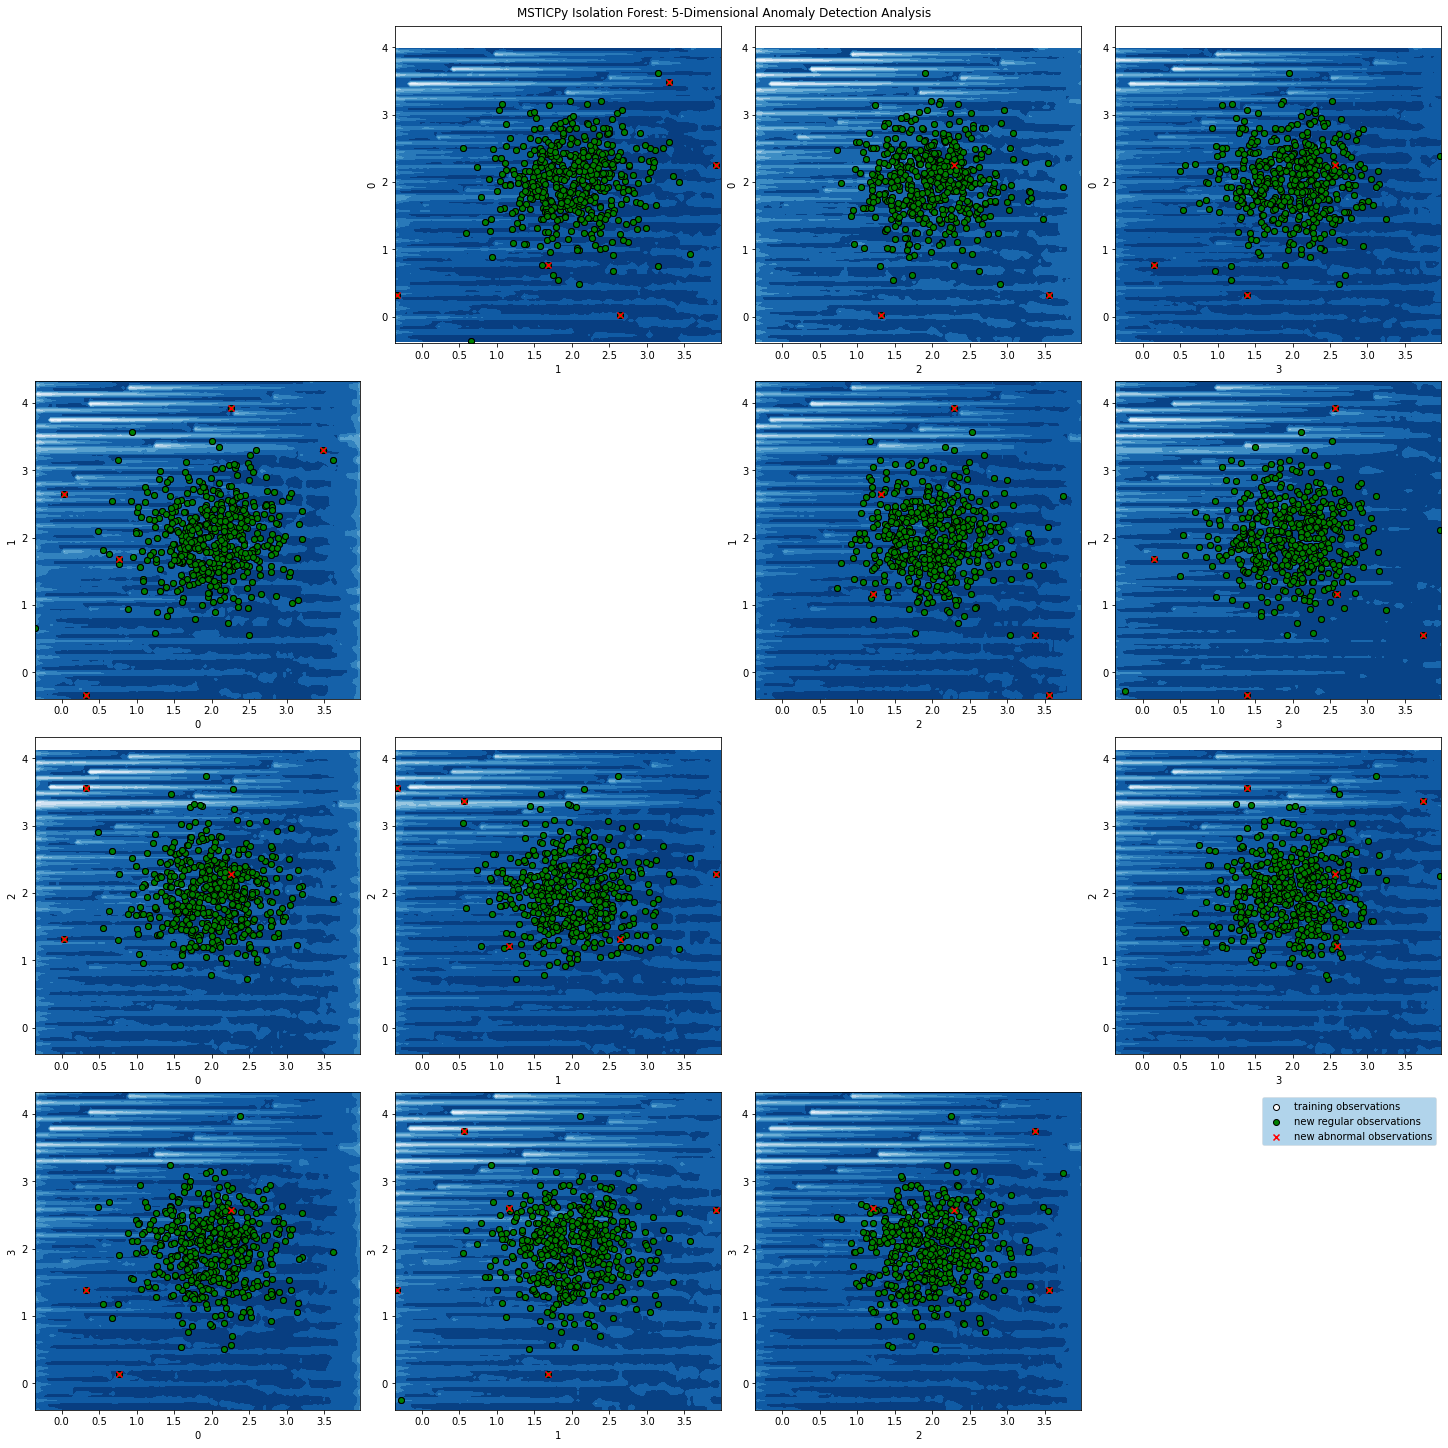


=== DATA EXPORT ===
Complete dataset with anomaly predictions available in 'df' DataFrame
Columns available: ['feature1', 'feature2', 'feature3', 'feature4', 'training_outliers', 'anomaly_prediction', 'is_anomaly']
Use df[df['is_anomaly']] to access detected anomalies
Use df[~df['is_anomaly']] to access normal data points


In [ ]:
print("\nGenerating anomaly detection visualization...")
plot_outlier_results(
    clf=clf,  # Trained Isolation Forest model
    x=all_features_data,  # Original training data
    x_predict=all_features_data,  # Prediction data
    x_outliers=detected_outliers,  # Detected outlier points
    feature_columns=list(range(n_features)),  # Use feature indices for visualization
    plt_title="MSTICPy Isolation Forest: 5-Dimensional Anomaly Detection Analysis",
)

# Save results for further analysis (optional)
print("\n=== DATA EXPORT ===")
print("Complete dataset with anomaly predictions available in 'df' DataFrame")
print(f"Columns available: {df.columns.tolist()}")
print("Use df[df['is_anomaly']] to access detected anomalies")
print("Use df[~df['is_anomaly']] to access normal data points")

## Appendix

### Differences between detected and training labeled

In [6]:
# outlier samples from prediction result
display(" Anomaly detected samples ")
display(df[df["is_anomaly"]])
# outlier samples from training labeled datasets
display(" Outliers training samples ")
display(df[df["training_outliers"] == 1])

# differences between training labeled outliers and anomalies detected
# Query string for the specified condition
query_str = "((is_anomaly == True) & (training_outliers == 0)) | ((is_anomaly == False) & (training_outliers == 1))"

# Apply the query to filter the DataFrame
display(df.query(query_str))

' Anomaly detected samples '

,feature1,feature2,feature3,feature4,training_outliers,anomaly_prediction,is_anomaly
302,2.257524,3.926366,2.285445,2.567783,0,-1,True
324,-1.615896,-1.892302,-1.745866,-0.036881,0,-1,True
363,-2.463465,-2.029763,-3.620634,-2.512194,0,-1,True
990,-2.020296,1.161901,1.207774,2.596137,1,-1,True
991,-0.658331,-3.415319,-1.810669,3.840044,1,-1,True
992,0.770069,1.677897,-3.941137,0.145646,1,-1,True
993,-3.699771,0.553842,3.366167,3.747353,1,-1,True
994,0.324421,-0.334362,3.560137,1.388879,1,-1,True
997,0.029755,2.641623,1.312098,-1.293057,1,-1,True
998,3.484184,3.297661,-2.325213,-3.684659,1,-1,True


' Outliers training samples '

,feature1,feature2,feature3,feature4,training_outliers,anomaly_prediction,is_anomaly
990,-2.020296,1.161901,1.207774,2.596137,1,-1,True
991,-0.658331,-3.415319,-1.810669,3.840044,1,-1,True
992,0.770069,1.677897,-3.941137,0.145646,1,-1,True
993,-3.699771,0.553842,3.366167,3.747353,1,-1,True
994,0.324421,-0.334362,3.560137,1.388879,1,-1,True
995,-3.480806,-0.274195,-2.078040,-0.241565,1,1,False
996,-0.356275,0.657158,-1.145836,-2.685836,1,1,False
997,0.029755,2.641623,1.312098,-1.293057,1,-1,True
998,3.484184,3.297661,-2.325213,-3.684659,1,-1,True
999,1.930470,2.620882,3.742917,3.118691,1,1,False


,feature1,feature2,feature3,feature4,training_outliers,anomaly_prediction,is_anomaly
302,2.257524,3.926366,2.285445,2.567783,0,-1,True
324,-1.615896,-1.892302,-1.745866,-0.036881,0,-1,True
363,-2.463465,-2.029763,-3.620634,-2.512194,0,-1,True
995,-3.480806,-0.274195,-2.078040,-0.241565,1,1,False
996,-0.356275,0.657158,-1.145836,-2.685836,1,1,False
999,1.930470,2.620882,3.742917,3.118691,1,1,False


## Conclusion

Comparing among the jupyter notebooks in [

    Outliers-IsolationForest.ipynb,
    
    Outliers-IsolationForest_timeseries.ipynb,
    
    Outliers-RobustRandomCutForest.ipynb,
    
    Outliers-RobustRandomCutForest_timeseries.ipynb,

], 

You can find the differences between IsolationForest and RobustRandomCutForest for some anomaly detected points.

In fact, IsolationForest is also found to be faster and more accurate for `non-time series data`.

This is because RRCF is good at detecting trend changes and correlations in multidimensional features and the features are suitable for time series datasets. 